# ITT-MCT Schematic Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **ITT-MCT Schematic (F₁₂)** model to steady-state flow curve data
2. Understand the glass transition: **ε = (v₂ - 4)/4** controls fluid vs glass state
3. Analyze the yield stress from the non-ergodicity parameter **f**
4. Use NLSQ warm-start for efficient Bayesian inference with NUTS
5. Extract posterior distributions for 4 model parameters (v₁ fixed at 0)
6. Calibrate parameters for downstream synthetic data generation (NB03, NB04, NB05)

## Prerequisites

- Basic RheoJAX usage (basic/01_quick_start.ipynb)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTSchematic

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_carbopol_flow_curve,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_schematic_param_names,
    interpret_glass_state,
    compute_f12_memory_kernel,
    compute_gaussian_decorrelation,
    compute_non_ergodicity_parameter,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: ITT-MCT Schematic F₁₂ Model

The **F₁₂ Schematic Model** is a simplified Mode-Coupling Theory that captures the essential physics of the glass transition with minimal parameters. It describes **dense colloidal suspensions** where particles become caged by their neighbors.

### Key Physics

**Density correlator Φ(t)** measures structural relaxation:
- Φ(0) = 1 (initial structure)
- Φ(∞) = 0 in fluid state (ergodic)
- Φ(∞) = f > 0 in glass state (non-ergodic, arrested dynamics)

**Memory kernel** m(Φ) = v₁Φ + v₂Φ² describes cage effect:
- v₂ controls glass transition strength
- Glass transition at v₂ = 4 (for v₁ = 0)

**Strain decorrelation** h(γ) = exp(-(γ/γc)²):
- Shear breaks cages
- γc is critical strain (~0.1 typically)

### Key Equations

**MCT integro-differential equation**:
$$
\frac{\partial \Phi}{\partial t} + \Gamma\left[\Phi + \int_0^t m(\Phi(s)) \frac{\partial \Phi}{\partial s} ds\right] = 0
$$

**Separation parameter** (distance from glass transition):
$$
\varepsilon = \frac{v_2 - v_{2,c}}{v_{2,c}} = \frac{v_2 - 4}{4}
$$

**Steady-state stress** (flow curve):
$$
\sigma = G_\infty \dot{\gamma} \int_0^\infty \Phi(t)^2 h(\dot{\gamma}t) dt
$$

### Parameters (5 total, 4 fitted)

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| **v1** | v₁ | Linear vertex (fixed = 0) | 0 |
| **v2** | v₂ | Quadratic vertex | 2 - 8 |
| **Gamma** | Γ | Bare relaxation rate (1/s) | 0.1 - 1000 |
| **gamma_c** | γc | Critical strain | 0.05 - 0.3 |
| **G_inf** | G∞ | High-frequency modulus (Pa) | 10 - 10⁶ |

### Physical Regimes

| Condition | State | Behavior |
|-----------|-------|----------|
| v₂ < 4 (ε < 0) | Fluid | Viscous flow, no yield stress |
| v₂ = 4 (ε = 0) | Critical | Power-law rheology |
| v₂ > 4 (ε > 0) | Glass | Yield stress, arrested dynamics |

## 3. Load Data

We use the carbopol flow curve data from Wei et al. 2018 (J. Rheol). While carbopol is a polymer gel rather than a colloidal glass, its yield-stress behavior makes it useful for demonstrating the MCT modeling workflow.

In [3]:
# Load ARES rate sweep up data
gamma_dot, stress = load_carbopol_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


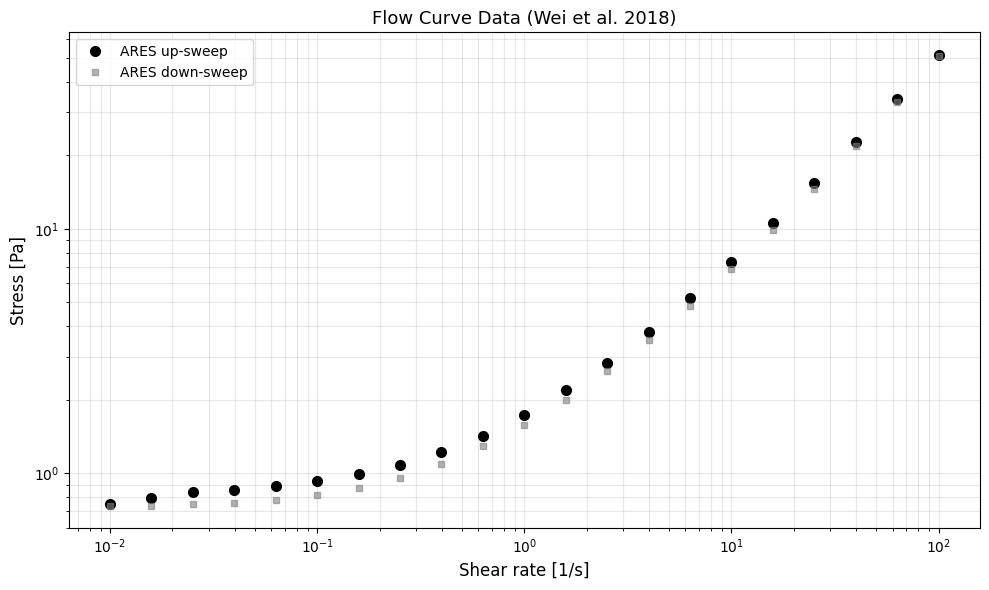

In [4]:
# Also load down-sweep for hysteresis comparison
gamma_dot_down, stress_down = load_carbopol_flow_curve(instrument="ARES_down")

# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="ARES up-sweep")
ax.loglog(gamma_dot_down, stress_down, "s", color="gray", markersize=5, 
          alpha=0.6, label="ARES down-sweep")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Flow Curve Data (Wei et al. 2018)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Create Model and Initial Fit

We create the Schematic model in a glass state (ε > 0) to capture the yield stress.

In [5]:
# Create model in glass state
model = ITTMCTSchematic(epsilon=0.05)  # Start in glass state

# Check initial glass state
print("Initial model state:")
print(model)
print()
print_glass_state_summary(model)

Initial model state:
ITTMCTSchematic(ε=0.050 [glass], v₂=4.20, h(γ)=gaussian, m=simplified, σ=schematic, G_inf=1.00e+06 Pa)


Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0500
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress


In [6]:
# Fit to flow curve data
# Note: v1 is fixed at 0, we fit v2, Gamma, gamma_c, G_inf
t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve", method='scipy')
t_nlsq = time.time() - t0

# Get parameter names (excluding v1 which is fixed)
param_names = ["v2", "Gamma", "gamma_c", "G_inf"]

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 134.10 s

Fitted parameters:
  v2         = 0.6645
  Gamma      = 1294
  gamma_c    = 0.01
  G_inf      = 5.175e+05


In [7]:
# Compute fit quality
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R^2:   -65779.821218
  RMSE:  3292 Pa
  NRMSE: 6492.2636%


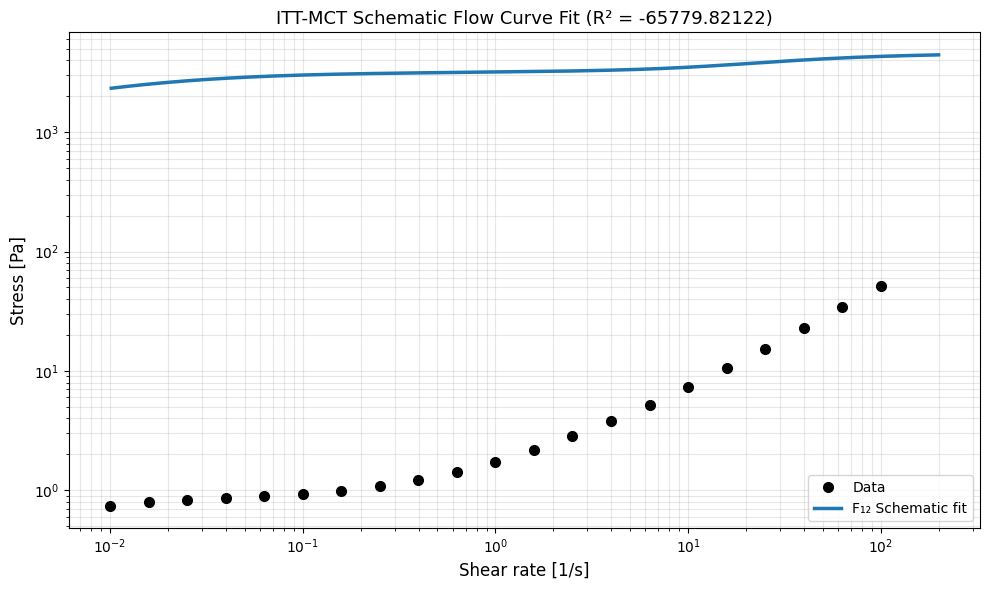

In [8]:
# Plot fit with data
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred_fine = model.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.loglog(gamma_dot_fine, stress_pred_fine, "-", lw=2.5, color="C0", 
          label="F₁₂ Schematic fit")

# Add yield stress reference
info = model.get_glass_transition_info()
if info["is_glass"]:
    f_neq = info.get("f_neq", 0.3)
    G_inf = model.parameters.get_value("G_inf")
    gamma_c = model.parameters.get_value("gamma_c")
    sigma_y = G_inf * gamma_c * f_neq
    ax.axhline(sigma_y, color="red", linestyle="--", alpha=0.5, 
               label=f"σ_y ≈ {sigma_y:.1f} Pa")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"ITT-MCT Schematic Flow Curve Fit (R² = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Physical Analysis: Glass Transition State

In [9]:
# Analyze glass state after fitting
print("Fitted Model State:")
print("=" * 50)
print_glass_state_summary(model)

# Extract key physics
v2 = model.parameters.get_value("v2")
Gamma = model.parameters.get_value("Gamma")
gamma_c = model.parameters.get_value("gamma_c")
G_inf = model.parameters.get_value("G_inf")

print(f"\nKey Physical Properties:")
print(f"  Bare relaxation time: τ₀ = 1/Γ = {1/Gamma:.4g} s")
print(f"  Critical strain: γc = {gamma_c:.4g}")
print(f"  High-freq modulus: G∞ = {G_inf:.4g} Pa")

# Compute memory kernel at equilibrium
f_neq = compute_non_ergodicity_parameter(0, v2)
m_eq = compute_f12_memory_kernel(f_neq, 0, v2)
print(f"\nMemory kernel at equilibrium:")
print(f"  Non-ergodicity parameter: f = {f_neq:.4g}")
print(f"  m(f) = v₂f² = {m_eq:.4g}")

Fitted Model State:

Glass Transition State
State: FLUID
Separation parameter: epsilon = -0.8315
  -> Correlator decays to 0 (ergodic dynamics)
  -> Material flows like a viscous liquid

Key Physical Properties:
  Bare relaxation time: τ₀ = 1/Γ = 0.0007727 s
  Critical strain: γc = 0.01
  High-freq modulus: G∞ = 5.175e+05 Pa

Memory kernel at equilibrium:
  Non-ergodicity parameter: f = 0
  m(f) = v₂f² = 0


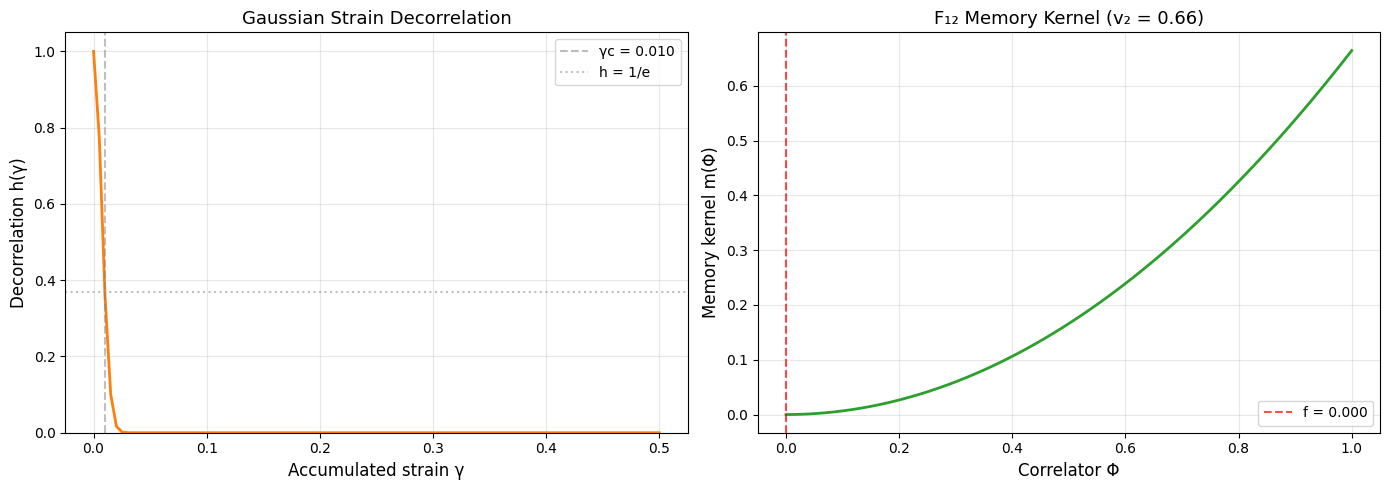

In [10]:
# Visualize strain decorrelation and memory kernel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Strain decorrelation
gamma_array = np.linspace(0, 0.5, 100)
h_gamma = compute_gaussian_decorrelation(gamma_array, gamma_c)
ax1.plot(gamma_array, h_gamma, lw=2, color="C1")
ax1.axvline(gamma_c, color="gray", linestyle="--", alpha=0.5, 
            label=f"γc = {gamma_c:.3f}")
ax1.axhline(np.exp(-1), color="gray", linestyle=":", alpha=0.5, 
            label="h = 1/e")
ax1.set_xlabel("Accumulated strain γ", fontsize=12)
ax1.set_ylabel("Decorrelation h(γ)", fontsize=12)
ax1.set_title("Gaussian Strain Decorrelation", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# Right: Memory kernel
phi_array = np.linspace(0, 1, 100)
m_phi = compute_f12_memory_kernel(phi_array, 0, v2)
ax2.plot(phi_array, m_phi, lw=2, color="C2")
ax2.axvline(f_neq, color="red", linestyle="--", alpha=0.7, 
            label=f"f = {f_neq:.3f}")
ax2.set_xlabel("Correlator Φ", fontsize=12)
ax2.set_ylabel("Memory kernel m(Φ)", fontsize=12)
ax2.set_title(f"F₁₂ Memory Kernel (v₂ = {v2:.2f})", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling.

In [11]:
try:
    # Prepare warm-start from NLSQ
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    print("Warm-start values:")
    for name, val in initial_values.items():
        print(f"  {name:10s} = {val:.4g}")
    
    # Fast demo config (production: uncomment below)
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    # NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production
    
    print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        gamma_dot,
        stress,
        test_mode="flow_curve",
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:NUTS sampling failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_stat

ERROR:rheojax.core.bayesian:bayesian_inference failed: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_state(
  

Warm-start values:
  v2         = 0.6645
  Gamma      = 1294
  gamma_c    = 0.01
  G_inf      = 5.175e+05

Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.
NLSQ results are reported above.


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.1 for demo) and effective sample size (ESS, target > 50 for demo).

In [12]:
if result is not None:
    # Convergence diagnostics table
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


### 5.3 ArviZ Diagnostic Plots

In [13]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (ITT-MCT Schematic)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Pair plot for correlations
    axes = az.plot_pair(
        idata,
        var_names=param_names,
        kind="scatter",
        divergences=True,
        figsize=(10, 10),
    )
    fig = axes.ravel()[0].figure
    fig.suptitle("Parameter Correlations", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    # Forest plot (credible intervals)
    axes = az.plot_forest(
        idata,
        var_names=param_names,
        combined=True,
        hdi_prob=0.95,
        figsize=(10, 6),
    )
    fig = axes.ravel()[0].figure
    fig.suptitle("95% Credible Intervals", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


### 5.4 Posterior Predictive Check

In [16]:
if result is not None:
    # Posterior predictive with 95% credible intervals
    posterior = result.posterior_samples
    n_draws = min(100, len(list(posterior.values())[0]))
    gamma_dot_pred = np.logspace(
        np.log10(gamma_dot.min()) - 0.3,
        np.log10(gamma_dot.max()) + 0.2,
        100,
    )
    
    # Generate predictions from posterior samples
    pred_samples = []
    for i in range(n_draws):
        # Temporarily set parameters
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        pred_i = model.predict(gamma_dot_pred, test_mode="flow_curve")
        pred_samples.append(np.array(pred_i))
    
    pred_samples = np.array(pred_samples)
    pred_median = np.median(pred_samples, axis=0)
    pred_lo = np.percentile(pred_samples, 2.5, axis=0)
    pred_hi = np.percentile(pred_samples, 97.5, axis=0)
    
    # Restore original parameters
    for name, val in initial_values.items():
        model.parameters.set_value(name, val)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", 
                    label="95% CI")
    ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", 
              label="Posterior median")
    ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
    ax.set_xlabel("Shear rate [1/s]", fontsize=12)
    ax.set_ylabel("Stress [Pa]", fontsize=12)
    ax.set_title("Posterior Predictive Check", fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which="both")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


### 5.5 Parameter Summary

In [17]:
if result is not None:
    # NLSQ vs Bayesian comparison table
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 6. Physical Interpretation

### Mode-Coupling Theory Insights

The fitted parameters reveal the material's proximity to the glass transition:

**Separation parameter ε:**
- ε > 0 indicates a glass state with arrested dynamics
- Larger ε means deeper into the glass, stronger cage effect

**Non-ergodicity parameter f:**
- f > 0 means the correlator doesn't decay to zero
- Related to the localization length (how far particles can move in their cage)

**Yield stress:**
- σ_y ~ G∞ × γc × f
- Arises from the arrested structure that must be broken by shear

### Flow Curve Regimes

1. **Low shear rates (γ̇ → 0):**
   - Stress approaches yield stress σ_y
   - Structure remains largely intact

2. **Intermediate shear rates:**
   - Shear thinning from cage breaking
   - Decorrelation h(γ) reduces effective viscosity

3. **High shear rates:**
   - Newtonian-like regime
   - σ ~ η∞ × γ̇ where η∞ ~ G∞/Γ

In [18]:
# Summary of physical interpretation
info = model.get_glass_transition_info()
print("Physical Interpretation Summary")
print("=" * 50)
print(interpret_glass_state(info))

print("\nFlow Curve Analysis:")
v2 = model.parameters.get_value("v2")
Gamma = model.parameters.get_value("Gamma")
G_inf = model.parameters.get_value("G_inf")
gamma_c = model.parameters.get_value("gamma_c")
f_neq = compute_non_ergodicity_parameter(0, v2)

sigma_y = G_inf * gamma_c * f_neq
eta_high = G_inf / Gamma

print(f"  Yield stress: σ_y ≈ G∞ × γc × f = {sigma_y:.2f} Pa")
print(f"  High-shear viscosity: η∞ ≈ G∞/Γ = {eta_high:.4g} Pa.s")

Physical Interpretation Summary
State: FLUID
Separation parameter: epsilon = -0.8315
  -> Correlator decays to 0 (ergodic dynamics)
  -> Material flows like a viscous liquid

Flow Curve Analysis:
  Yield stress: σ_y ≈ G∞ × γc × f = 0.00 Pa
  High-shear viscosity: η∞ ≈ G∞/Γ = 399.9 Pa.s


## 7. Save Results

Save parameters for use in synthetic data generation:
- **NB03:** Stress Relaxation (two-step β and α processes)
- **NB04:** Creep (delayed yielding)
- **NB05:** SAOS (G' plateau from f, G'' peak)

In [19]:
# Save results for downstream notebooks
save_itt_mct_results(model, result, "schematic", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB03: Stress Relaxation (β and α processes)")
print("  - NB04: Creep (delayed yielding)")
print("  - NB05: SAOS (G' plateau, G'' peak)")

  Skipping posterior (Bayesian inference not available for ITT-MCT)


Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/schematic/flow_curve/
  nlsq_params_flow_curve.json: 4 parameters

Parameters saved for synthetic data generation in:
  - NB03: Stress Relaxation (β and α processes)
  - NB04: Creep (delayed yielding)
  - NB05: SAOS (G' plateau, G'' peak)


## Key Takeaways

1. **ITT-MCT Schematic (F₁₂)** captures glass transition physics with 4 fitted parameters:
   - v₂ controls glass transition (critical at v₂ = 4)
   - Γ sets the bare relaxation rate
   - γc is the critical strain for cage breaking
   - G∞ is the high-frequency modulus

2. **Glass state (ε > 0)** exhibits:
   - Non-zero non-ergodicity parameter f
   - Yield stress σ_y ~ G∞ × γc × f
   - Arrested dynamics (correlator plateaus)

3. **Flow curve** shows:
   - Yield plateau at low shear rates
   - Shear thinning from cage breaking h(γ)
   - Approach to Newtonian at high rates

4. **NLSQ warm-start is critical** for efficient Bayesian inference

5. **Calibrated parameters** will generate synthetic data for:
   - Relaxation: two-step decay (β fast + α slow processes)
   - Creep: delayed yielding below σ_y
   - SAOS: G' plateau from f, G'' peak from α-relaxation

### Next Steps

- **NB02:** Startup Shear (stress overshoot from cage breaking)
- **NB03:** Stress Relaxation (synthetic, from calibrated parameters)
- **NB04:** Creep (synthetic, from calibrated parameters)
- **NB05:** SAOS (synthetic, from calibrated parameters)
- **NB06:** LAOS (real PNAS data, harmonic analysis)